<a href="https://colab.research.google.com/github/simasuiyuan/NUS_learning/blob/main/VoG_Colab_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variance of Gradients (VoG)

###  Chirag Agrawal, Daniel D'souza, Sara Hooker


**tl;dr** VoG is an efficient metric to rank data by difficulty and to surface a tractable subset of the most challenging examples for human-in-the-loop auditing. Data points with high VoG scores are far more difficult for the model to learn and over-index on corrupted or memorized examples.

[Paper Link](https://arxiv.org/abs/2008.11600)



## VoG Preliminary 

Reasoning about model behavior is often easier when presented with a subset of data points that are relatively more difficult for a trained model to learn. 

**Variance of Gradients (VOG)** ranks examples by computing the class normalized variance in gradients for each example over the course of training. Examples that a model has difficulty learning exhibit higher variance in gradient updates over the course of training. On the other hand, backpropagated gradients of the samples that are relatively easier to learn will have lower variance because performance on that example does not consistently dominate the loss over the course of training, i.e., the gradient updates for the relatively easier examples are expected to stabilize early in training and converge to a narrow range of values. 

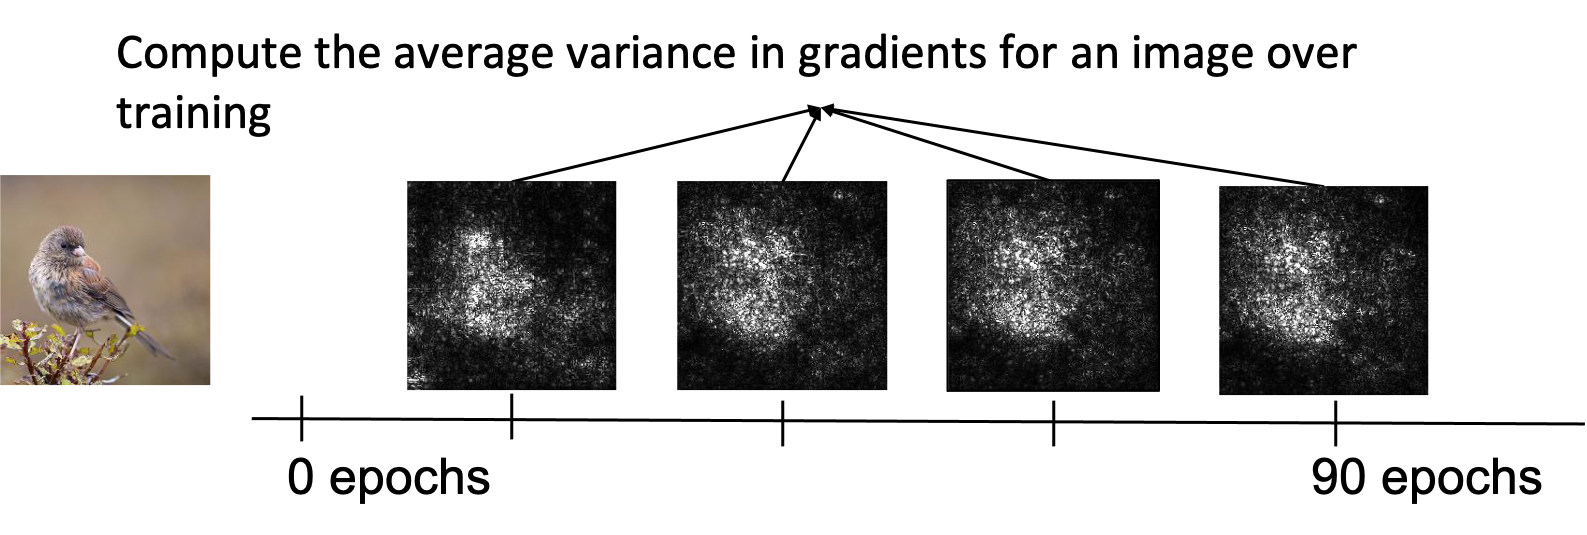

#### Download VoG checkpoints for MNIST, CIFAR-10, and CIFAR-100 datasets

---

In [ ]:
######### Download VoG checkpoints #########
import gdown

url='https://drive.google.com/uc?id=13on3KFgoTIh0pPKspTk6k-VJxBsZuRJy&export=download'

output = 'npyfiles.zip'
gdown.download(url, output, quiet=False)

!unzip -o npyfiles.zip

Downloading...
From: https://drive.google.com/uc?id=13on3KFgoTIh0pPKspTk6k-VJxBsZuRJy&export=download
To: /content/npyfiles.zip
100%|██████████| 7.19M/7.19M [00:00<00:00, 97.0MB/s]


Archive:  npyfiles.zip
  inflating: c10_vog.npy             
  inflating: c10_test_vog.npy        
  inflating: mnist_vog.npy           
  inflating: c100_pred.npy           
  inflating: c10_gt.npy              
  inflating: c100_test_pred.npy      
  inflating: c10_test_pred.npy       
  inflating: mnist_gt.npy            
  inflating: c100_gt.npy             
  inflating: c100_test_gt.npy        
  inflating: mnist_pred.npy          
  inflating: c100_test_vog.npy       
  inflating: c100_vog.npy            
  inflating: c10_test_gt.npy         
  inflating: c10_pred.npy            


#### Setting up the seeds for reproducibility and importing libraries

---


In [ ]:
######### Setting Seeds for Reproducibility #########

# Set a seed value
seed_value = 912
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os

os.environ["PYTHONHASHSEED"] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random

random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np

np.random.seed(seed_value)
# 4. Set Torch seed at a fixed value
import torch
seed = 912
torch.manual_seed(seed)

# 5. CuDNN settings
REPRODUCIBLE = True
RECORD_TRAIN_SNAPSHOTS = True
RECORD_TEST_SNAPSHOTS = False

if REPRODUCIBLE:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
else:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE -> {0}".format(device))
#####################################################

# Libraries
import warnings
warnings.filterwarnings('ignore')

# Torch dependencies
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

# Plotting
import matplotlib.pyplot as plt
from google.colab import widgets
import matplotlib.gridspec as gridspec

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})
plt.rc('font', family='sans-serif')
plt.rcParams["axes.grid"] = False

DEVICE -> cpu


## Enter VoG details
1. Enter the dataset which you would like to audit from the drop down menu.
2. Enter the training stage you would like to visualize: [0, 20%], [20, 40%], [40, 60%], [60, 80%], [80, 100%].

In [ ]:
# Dataset: CIFAR-10 / CIFAR-100
DATASET = 'CIFAR-10' #@param ["CIFAR-10", "CIFAR-100"]
# Dataset split: TRAINING / TESTING
SPLIT = 'TRAINING' #@param ["TRAINING", "TESTING"]
# Training Stage: analyze the VoG score as the training progresses
TRAINING_STAGE = 80 #@param {type:"slider", min:0, max:100, step:20}

#### Preparing the dataset and dataloader for VoG analysis

---

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Done!!

==> Visualizing samples from the dataset


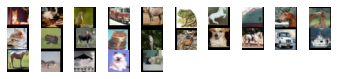

In [ ]:
print("==> Preparing data..")
if DATASET == 'CIFAR-10':
  # Cifar-10 Data
  if SPLIT == 'TRAINING':
    transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),                                        
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, 
                                              shuffle=False, num_workers=2)
    loader = trainloader
    rand_samp = np.random.randint(1, 50000, 25)
  elif SPLIT == 'TESTING':
    transform_test = transforms.Compose([                                     
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                          download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, 
                                            shuffle=False, num_workers=2)
    loader = testloader
    rand_samp = np.random.randint(1, 10000, 25)

  dataset_images = []
  for batch_idx, (inputs, targets) in enumerate(loader):
        train_inputs, train_targets = inputs.to(device), targets.to(device)
        for ii in range(train_inputs.shape[0]):
          dataset_images.append((train_inputs[ii].detach().cpu()*torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) +
             torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)).permute(1, 2, 0).numpy())
  print("Done!!\n")

  # Visualize some random images from the dataset
  print("==> Visualizing samples from the dataset")
  plt.figure()
  for num, ii in enumerate(rand_samp):
    plt.subplot(10, 10, num+1)
    plt.imshow((255*dataset_images[ii]).astype('uint8'))
    plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

elif DATASET == 'CIFAR-100':
  # Cifar-100 Data
  if SPLIT == 'TRAINING':
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762)),
    ])
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, 
                                              shuffle=False, num_workers=4)
    loader = trainloader
    rand_samp = np.random.randint(1, 50000, 25)
  elif SPLIT == 'TESTING':
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762)),
    ])

    testset = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                             download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, 
                                              shuffle=False, num_workers=4)
    loader = testloader
    rand_samp = np.random.randint(1, 10000, 25)

  dataset_images = []
  for batch_idx, (inputs, targets) in enumerate(loader):
        train_inputs, train_targets = inputs.to(device), targets.to(device)
        for ii in range(train_inputs.shape[0]):
          dataset_images.append((train_inputs[ii].detach().cpu()*torch.tensor([0.2673, 0.2564, 0.2762]).view(3, 1, 1) +
             torch.tensor([0.5071, 0.4866, 0.4409]).view(3, 1, 1)).permute(1, 2, 0).numpy())
  print("Done!!\n")

  # Visualize some random images from the dataset
  print("==> Visualizing samples from the dataset")
  plt.figure()
  for num, ii in enumerate(rand_samp):
    plt.subplot(5, 5, num+1)
    plt.imshow((255*dataset_images[ii]).astype('uint8'))
    plt.axis('off')
  plt.subplots_adjust(wspace=0.0, hspace=0.0)
  plt.show()
else:
  assert False, 'Invalid choice!! Choose a dataset from the dropdown menu.'

#### Loading VoG scores

---

In [ ]:
# Read VoG scores
if DATASET == 'CIFAR-10':
  if SPLIT == 'TRAINING':
    data_vog = np.load('./c10_vog.npy')[TRAINING_STAGE//20 - 1]
    data_gt = np.load('./c10_gt.npy')[TRAINING_STAGE//20 - 1]
    data_pred = np.load('./c10_pred.npy')[TRAINING_STAGE//20 - 1]
  elif SPLIT == 'TESTING':
    data_vog = np.load('./c10_test_vog.npy')[TRAINING_STAGE//20 - 1]
    data_gt = np.load('./c10_test_gt.npy')[TRAINING_STAGE//20 - 1]
    data_pred = np.load('./c10_test_pred.npy')[TRAINING_STAGE//20 - 1]    
elif DATASET == 'CIFAR-100':
  if SPLIT == 'TRAINING':  
    data_vog = np.load('./c100_vog.npy')[TRAINING_STAGE//20 - 1]
    data_gt = np.load('./c100_gt.npy')[TRAINING_STAGE//20 - 1]
    data_pred = np.load('./c100_pred.npy')[TRAINING_STAGE//20 - 1]
  elif SPLIT == 'TESTING':  
    data_vog = np.load('./c100_test_vog.npy')[TRAINING_STAGE//20 - 1]
    data_gt = np.load('./c100_test_gt.npy')[TRAINING_STAGE//20 - 1]
    data_pred = np.load('./c100_test_pred.npy')[TRAINING_STAGE//20 - 1]

#### Visualizing easy and challenging exmaples across the whole dataset using VoG scores
---

## === Auditing the dataset wrt VoG scores === ##
==> Low VoG score images are clean texture-biased images whereas 
 High VoG score images are blury where the objects are mostly 
 indistinguishable from the background.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

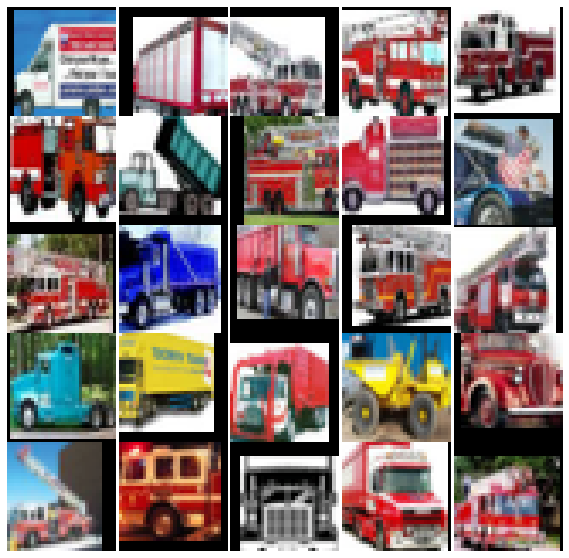

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

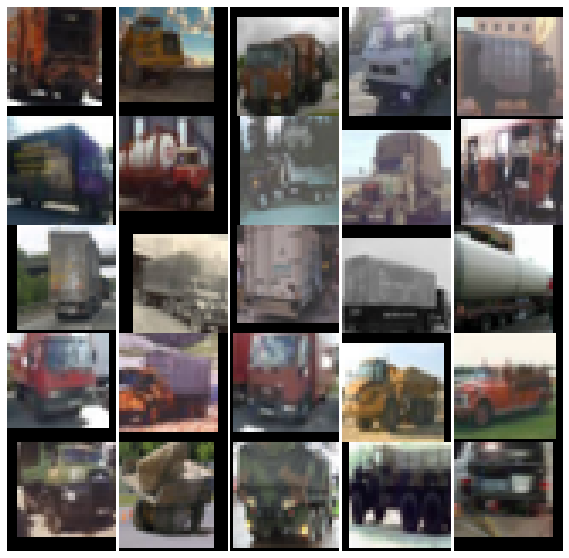

<IPython.core.display.Javascript object>

In [ ]:
# Visualize images from the VoG deciles
ascend_vog = sorted(range(len(data_vog)), key=lambda k: data_vog[k], reverse=False)
descend_vog = ascend_vog[::-1]

def create_tab(x, category, class_id='all'):
    plt.figure(figsize=(10, 10))
    plot_ind = 1
    if category == 'low':
      vog_ind = ascend_vog
    elif category == 'high':
      vog_ind = descend_vog
    else:
      assert False, 'Invalid choice!!'

    for ind in vog_ind:
        if class_id != 'all':
          if data_pred[ind] == int(class_id) == data_gt[ind]:
            plt.subplot(5, 5, plot_ind)
            plt.imshow((255*dataset_images[ind]).astype('uint8'))
            plt.axis('off')
            plot_ind += 1            
        else:
          plt.subplot(10, 10, plot_ind)
          plt.imshow((255*dataset_images[ind]).astype('uint8'))
          plt.axis('off')
          plot_ind += 1
        if plot_ind > 25:
          break
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()

def vog_audit(class_id='all'):  
  t = widgets.TabBar(["Low VoG samples", "High VoG samples"])
  with t.output_to(0):
    create_tab(data_vog, category='low', class_id=class_id)

  with t.output_to(1):
    create_tab(data_vog, category='high', class_id=class_id)
    
print('## === Auditing the dataset wrt VoG scores === ##')
print('==> Low VoG score images are clean texture-biased images whereas \n High VoG score images are blury where the objects are mostly \n indistinguishable from the background.')
vog_audit(class_id=9)

#### Enter the class you would like to audit using VoG scores

---

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

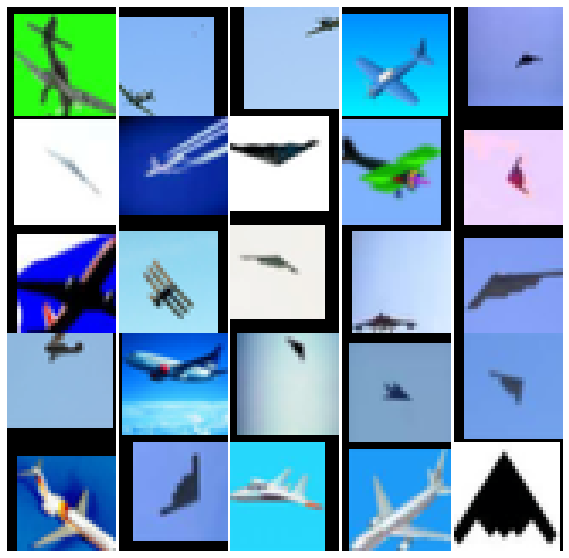

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

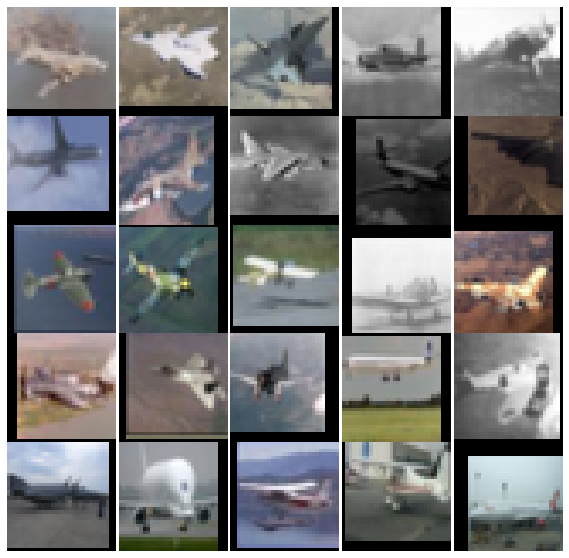

<IPython.core.display.Javascript object>

In [ ]:
# Audit the VoG samples for an individual class
c10_audit_class = 'plane' #@param ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
c100_audit_class = 'chair' #@param ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle','chair','chimpanzee','clock','cloud', 'cockroach','couch','crab','crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

c10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

c100_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 
                'beaver', 'bed', 'bee', 'beetle', 'bicycle', 
                'bottle', 'bowl', 'boy', 'bridge', 'bus', 
                'butterfly', 'camel', 'can', 'castle', 
                'caterpillar', 'cattle','chair','chimpanzee',
                'clock','cloud', 'cockroach','couch','crab', 
                'crocodile', 'cup', 'dinosaur', 'dolphin', 
                'elephant', 'flatfish', 'forest', 'fox', 'girl', 
                'hamster', 'house', 'kangaroo', 
                'computer_keyboard', 'lamp', 'lawn_mower', 
                'leopard', 'lion', 'lizard', 'lobster', 'man', 
                'maple_tree', 'motorcycle', 'mountain', 'mouse', 
                'mushroom', 'oak_tree', 'orange', 'orchid', 
                'otter', 'palm_tree', 'pear', 'pickup_truck', 
                'pine_tree', 'plain', 'plate', 'poppy', 
                'porcupine', 'possum', 'rabbit', 'raccoon', 
                'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 
                'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 
                'snake', 'spider', 'squirrel', 'streetcar', 
                'sunflower', 'sweet_pepper', 'table', 'tank', 
                'telephone', 'television', 'tiger', 'tractor', 
                'train', 'trout', 'tulip', 'turtle', 'wardrobe', 
                'whale', 'willow_tree', 'wolf', 'woman', 'worm']

if DATASET == 'CIFAR-10':
  CLASS_ID = c10_classes.index(c10_audit_class)
elif DATASET == 'CIFAR-100':
  CLASS_ID = c100_classes.index(c100_audit_class)
  print(f'==> Auditing Class: {c100_audit_class}')

vog_audit(class_id=CLASS_ID)